In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
import os
import pandas as pd
import torch
from dataset_preprocessing import TokenInfo
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import itertools
import pandas as pd
from tqdm import tqdm

## Importances

In [5]:
def get_importances():
    # print("this is wrong")
    dir = "./new_importances_data"
    imp_files = os.listdir(dir)
    imp_files = [file for file in imp_files if file.endswith(".pkl")]
    importances = {}
    for imp_file in tqdm(imp_files):
        importances.update(pd.read_pickle(f"{dir}/{imp_file}"))
    return importances

In [6]:
# imps = get_importances()

In [7]:
def get_avg_imporances(importances):
    avg_imps = [torch.zeros_like(imp) for imp in list(importances.values())[0]]
    for token, imps in tqdm(importances.items()):
        for i, layer_imps in enumerate(imps):
            avg_imps[i] += layer_imps / len(importances)
    # TODO think harder about averaging method
    return avg_imps

In [8]:
# avg_importances = get_avg_imporances(imps)

In [9]:
# pd.to_pickle(avg_importances, "./avg_importances.pkl")

In [10]:
!ls ../

baseline_dataset.pkl  cs229-project  pcs224n  tmp-cs229-project
cs229		      LLM-Pruner     tmp


In [11]:
avg_importances = pd.read_pickle("./avg_importances.pkl")

In [12]:
len(avg_importances)

24

## Model

In [13]:
model_id = "microsoft/phi-1_5"
model_revision = "349cf8b5e81fd5f791d1740da5de1313a0419bbd" # latest as of feb 1st

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

In [15]:
vocab = tokenizer.get_vocab()
len(vocab)

50295

In [16]:
# tokenizer.decode(token_info.get_prefixes(top_tokens[1000][0], 9, 10)[0])

In [17]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    revision=model_revision,
    trust_remote_code=True,
    # be careful with this?
    # torch_dtype=torch.float16,
    # attn_implementation="flash_attention_2",
)

## Prune Model

In [18]:
from prunners import prune_mlps_individually
from importances import get_mlps

In [19]:
mlps = get_mlps(model)

In [20]:
len(mlps), len(avg_importances)

(24, 24)

In [21]:
avg_importances = dict(zip(mlps, avg_importances))

In [22]:
prune_mlps_individually(avg_importances, 0.5)

In [23]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2048)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2048, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=2048, bias=True)
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((2048,), e

## New Dataset

In [24]:
from other_datasets import get_minipile, get_c4, get_wikitext2_filtered, get_bookcorpus, get_alpaca, QADataCollator, to_dataset
from dataset import get_baseline_dataset

/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [25]:
alpaca_train, alpaca_eval = get_alpaca(tokenizer, do_split=True)
# eval datasets
# tiny_text = get_baseline_dataset()["test"]
# c4 = get_c4(n=2000, do_split=False)
# minipile = get_minipile(n=2000, do_split=False)
wikitext = get_wikitext2_filtered(n=2000, do_split=False)
# bookcorpus = get_bookcorpus(n=2000, do_split=False)

2024-03-06 14:32:00.392 | INFO     | other_datasets:__init__:309 - Mean length of tokens per window: 111.64232
2024-03-06 14:32:01.056 | INFO     | other_datasets:__init__:309 - Mean length of tokens per window: 109.2675


## Metric Callback

In [26]:
from transformers import TrainerCallback

In [27]:
from evaluation import evaluate_on_nlp_tasks

In [28]:
class AccEvalCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.last_step=-1
    
    def on_evaluate(self, args, state, control, model, **kwargs):
        if state.global_step == self.last_step:
            return
        self.last_step = state.global_step
        train = model.training
        model.eval()
        with torch.no_grad():
            os.environ["TQDM_DISABLE"] = "1"
            eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=100)["results"]
            # import pdb; pdb.set_trace()
            eval_res = {k:v["acc,none"] for k,v in eval_res.items()}
            for k, v in eval_res.items():
                state.log_history.append(
                    {
                        k:v,
                        "epoch":state.epoch,
                        "step":state.global_step,
                    }
                )
            del os.environ['TQDM_DISABLE']
            print(eval_res)
        model.train(train)

In [29]:
class EnableMLPBias(TrainerCallback):
    def on_init_end(self, args, state, control, model, **kwargs):
        for n, p in model.named_parameters():
            if "base_layer" in n and "bias" in n:
                p.requires_grad = True

## Replace model modules

In [30]:
from experts import Experts, EmbeddingTokenIdxTracker, mark_only_adapters_as_trainable, prepare_as_if_peft_model, prepare_model_for_gradient_checkpointing
from importances import get_mlps
from post_training import get_lora_config, get_training_arguments

In [31]:
lora_config = get_lora_config(r=64)
training_arguments = get_training_arguments("./tmp")

In [32]:
training_arguments = prepare_as_if_peft_model(model, training_arguments, lora_config)

In [33]:
embed_tokens_new = EmbeddingTokenIdxTracker(model.get_submodule("model").get_submodule("embed_tokens"))

In [34]:
def get_layers(model):
    return model.get_submodule("model").get_submodule("layers")

In [35]:
layers = get_layers(model)

In [36]:
model.get_submodule("model").embed_tokens = embed_tokens_new

In [37]:
for i, layer in enumerate(layers):
    layer.mlp = Experts(
        model,
        layer.mlp,
        lora_config,
        i,
        embed_tokens_new.idx_tracker,
        layer.mlp.config,
    )

In [38]:
mark_only_adapters_as_trainable(model, lora_config)

In [39]:
prepare_model_for_gradient_checkpointing(model);

In [40]:
examples = ["hi this is an example", "hi this is an example"]

In [41]:
examples = torch.tensor(tokenizer.encode(examples)).view(-1, 5)

In [42]:
model.cuda();

In [43]:
_ = model(examples.cuda())

## Train Model

In [44]:
from post_training import get_lora_config, get_training_arguments
from dataset import get_baseline_dataset
from trl import SFTTrainer
from peft import LoraConfig
import transformers
from trl import SFTTrainer
from other_datasets import SFTTrainer_

In [45]:
# Setup model for training
model.config.use_cache = False
model.config.pretraining_tp = 1
model.gradient_checkpointing_enable()

In [46]:
# train_data, eval_data = minipile["train"], minipile["test"]
train_data, eval_data = alpaca_train, alpaca_eval
eval_datasets = {
    "alpaca":alpaca_eval,
    # "minipile":minipile,
    # "c4":c4,
    "wikitext":wikitext,
    # "tiny_text":tiny_text,
    # "bookcorpus":bookcorpus,
}

In [47]:
callbacks = [AccEvalCallback(), EnableMLPBias()]

In [48]:
# Setup tokenizer for trainign
tokenizer.pad_token = tokenizer.eos_token

In [49]:
training_arguments.save_strategy="no"

In [50]:
training_arguments.eval_steps = 100

In [51]:
trainer = SFTTrainer_(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_datasets,
    # peft_config=lora_config,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=False,
    dataset_text_field="text",
    max_seq_length=1024, # tweak this
    # TODO: think harder about the datacollator
    # data_collator=transformers.DataCollatorForSeq2Seq(
    #     tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
    # ),
    callbacks=callbacks,
    data_collator=QADataCollator(tokenizer),
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

2024-03-06:14:32:28,594 WARNING  [logging.py:61] Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [52]:
# trainer.evaluate(eval_datasets["alpaca"])

In [53]:
trainer.train()

Step,Training Loss,Validation Loss,Alpaca Loss,Wikitext Loss
100,2.043900,No log,2.046345,4.635422
200,1.853000,No log,1.859893,4.465142
300,1.761500,No log,1.807240,4.403878
400,1.729000,No log,1.779059,4.381928
500,1.770900,No log,1.761130,4.358023
600,1.729200,No log,1.749165,4.343743
700,1.765600,No log,1.738868,4.335640
800,1.701200,No log,1.730917,4.330366
900,1.681100,No log,1.728477,4.339777
1000,1.668100,No log,1.725516,4.340084


2024-03-06:14:59:45,521 WARNING  [huggingface.py:105] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-03-06:14:59:45,626 WARNING  [huggingface.py:315] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|████████████████████████████████████████████| 10

{'hellaswag': 0.47, 'piqa': 0.73, 'boolq': 0.7, 'winogrande': 0.63}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
You're using a CodeGenTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|████████████████████████████████████████████| 1000/1000 [06:38<00:00,  2.51it/s]

{'hellaswag': 0.45, 'piqa': 0.75, 'boolq': 0.7, 'winogrande': 0.62}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|████████████████████████████████████████████| 1000/1000 [06:38<00:00,  2.51it/s]

{'hellaswag': 0.45, 'piqa': 0.76, 'boolq': 0.72, 'winogrande': 0.61}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|████████████████████████████████████████████| 1000/1000 [06:38<00:00,  2.51it/s]

{'hellaswag': 0.44, 'piqa': 0.75, 'boolq': 0.73, 'winogrande': 0.61}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|████████████████████████████████████████████| 1000/1000 [06:38<00:00,  2.51it/s]

{'hellaswag': 0.44, 'piqa': 0.72, 'boolq': 0.73, 'winogrande': 0.61}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [54]:
trainer_state = trainer.state
pd.DataFrame(trainer_state.log_history).tail()

,loss,learning_rate,epoch,step,eval_alpaca_loss,eval_alpaca_runtime,eval_alpaca_samples_per_second,eval_alpaca_steps_per_second,hellaswag,piqa,boolq,winogrande,eval_wikitext_loss,eval_wikitext_runtime,eval_wikitext_samples_per_second,eval_wikitext_steps_per_second
171,NaN,NaN,1.320000,1100,1.722494,115.6916,17.287,2.161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172,NaN,NaN,1.319894,1100,NaN,NaN,NaN,NaN,0.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173,NaN,NaN,1.319894,1100,NaN,NaN,NaN,NaN,NaN,0.72,NaN,NaN,NaN,NaN,NaN,NaN
174,NaN,NaN,1.319894,1100,NaN,NaN,NaN,NaN,NaN,NaN,0.7,NaN,NaN,NaN,NaN,NaN
175,NaN,NaN,1.319894,1100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.61,NaN,NaN,NaN,NaN


In [55]:
pd.to_pickle(trainer.state, "./tmp/alpaca_trainer_state_0.5ratio_64lora.pkl")

### Evaluation

In [56]:
from evaluation import evaluate_on_nlp_tasks

In [57]:
model.eval();

In [58]:
with torch.no_grad():
    eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=300)

/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|████████████████████████████████████████████| 3000/3000 [25:28<00:00,  1.96it/s]
fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [59]:
eval_res["results"]

{'hellaswag': {'acc,none': 0.39, 'acc_norm,none': 0.46, 'alias': 'hellaswag'},
 'piqa': {'acc,none': 0.6933333333333334,
  'acc_norm,none': 0.7166666666666667,
  'alias': 'piqa'},
 'boolq': {'acc,none': 0.6233333333333333, 'alias': 'boolq'},
 'winogrande': {'acc,none': 0.57, 'alias': 'winogrande'}}

In [ ]:
eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=1000)

/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
 39%|███████████████▊                         | 3859/10000 [52:16<1:17:20,  1.32it/s]

In [ ]:
eval_res["results"]

## Save

In [ ]:
model.cpu();

In [ ]:
torch.save(model.state_dict(), "./tmp/alpaca_model_0.5ratio_64lora_state_dict")

## Looking at stats

In [ ]:
df = pd.DataFrame(trainer_state.log_history)

In [ ]:
metrics_df = df[["step", "hellaswag", "piqa", "boolq", "winogrande"]]

In [ ]:
metrics_df[["step", "boolq"]].dropna().set_index("step").plot()

In [ ]:
metrics_df[["step", "hellaswag"]].dropna().set_index("step").plot()

In [ ]:
metrics_df = df[["step", "piqa"]].dropna().set_index("step").plot()

In [ ]:
metrics_df = df[["step", "winogrande"]].dropna().set_index("step").plot()

In [ ]:
eval_df = df[["step", "eval_alpaca_loss", "eval_wikitext_loss"]].set_index("step")

In [ ]:
(eval_df / eval_df.max()).interpolate(method='linear').plot()

In [ ]:
df[["step", "eval_alpaca_loss", "loss"]].set_index("step").interpolate(method='linear').plot()

In [53]:
trainer.train()

Step,Training Loss,Validation Loss,Alpaca Loss,Wikitext Loss
100,2.043500,No log,2.045196,4.631973
200,1.852700,No log,1.859274,4.464230
300,1.761300,No log,1.806879,4.403234
400,1.728500,No log,1.778843,4.381326
500,1.770700,No log,1.760918,4.357485
600,1.728900,No log,1.749075,4.342896
700,1.765300,No log,1.738835,4.334788
800,1.701000,No log,1.730788,4.329589
900,1.681100,No log,1.728320,4.339268
1000,1.668000,No log,1.725523,4.339378


2024-03-05:16:33:20,063 WARNING  [huggingface.py:105] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-03-05:16:33:20,144 WARNING  [huggingface.py:315] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████████| 1000/1000 [10:52<00

{'hellaswag': 0.46, 'piqa': 0.73, 'boolq': 0.7, 'winogrande': 0.64}


You're using a CodeGenTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████████| 1000/1000 [11:02<00:00,  1.51it/s]


{'hellaswag': 0.43, 'piqa': 0.74, 'boolq': 0.7, 'winogrande': 0.62}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████████| 1000/1000 [10:59<00:00,  1.52it/s]


{'hellaswag': 0.45, 'piqa': 0.76, 'boolq': 0.71, 'winogrande': 0.62}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████████| 1000/1000 [06:41<00:00,  2.49it/s]

{'hellaswag': 0.44, 'piqa': 0.75, 'boolq': 0.73, 'winogrande': 0.61}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████████| 1000/1000 [06:42<00:00,  2.49it/s]

{'hellaswag': 0.44, 'piqa': 0.72, 'boolq': 0.73, 'winogrande': 0.61}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████████| 1000/1000 [06:45<00:00,  2.47it/s]

{'hellaswag': 0.43, 'piqa': 0.72, 'boolq': 0.73, 'winogrande': 0.61}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████████| 1000/1000 [06:36<00:00,  2.52it/s]

{'hellaswag': 0.43, 'piqa': 0.71, 'boolq': 0.72, 'winogrande': 0.62}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████████| 1000/1000 [06:42<00:00,  2.48it/s]

{'hellaswag': 0.42, 'piqa': 0.71, 'boolq': 0.72, 'winogrande': 0.62}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████████| 1000/1000 [06:38<00:00,  2.51it/s]

{'hellaswag': 0.42, 'piqa': 0.73, 'boolq': 0.72, 'winogrande': 0.61}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████████| 1000/1000 [06:45<00:00,  2.47it/s]

{'hellaswag': 0.42, 'piqa': 0.72, 'boolq': 0.7, 'winogrande': 0.6}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
 13%|███▋                        | 132/1000 [00:54<05:57,  2.43it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
S

{'hellaswag': 0.42, 'piqa': 0.73, 'boolq': 0.71, 'winogrande': 0.6}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█| 1000/1000 [08:16<00:00,  2.01it/s

{'hellaswag': 0.42, 'piqa': 0.73, 'boolq': 0.71, 'winogrande': 0.6}



fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█| 1000/1000 [12:58<00:00,  1.29it/s


{'hellaswag': 0.42, 'piqa': 0.73, 'boolq': 0.71, 'winogrande': 0.6}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


TrainOutput(global_step=1666, training_loss=1.7608014204922844, metrics={'train_runtime': 40159.2431, 'train_samples_per_second': 2.49, 'train_steps_per_second': 0.041, 'total_flos': 1.2195201950960026e+17, 'train_loss': 1.7608014204922844, 'epoch': 2.0})

In [55]:
trainer_state = trainer.state
pd.DataFrame(trainer_state.log_history).tail()

,loss,learning_rate,epoch,step,eval_alpaca_loss,eval_alpaca_runtime,eval_alpaca_samples_per_second,eval_alpaca_steps_per_second,hellaswag,piqa,...,winogrande,eval_wikitext_loss,eval_wikitext_runtime,eval_wikitext_samples_per_second,eval_wikitext_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
259,1.6490,2.298851e-06,1.96,1630,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260,1.6294,1.660281e-06,1.97,1640,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,1.6402,1.021711e-06,1.98,1650,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262,1.6494,3.831418e-07,1.99,1660,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,NaN,NaN,2.00,1666,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,40159.2431,2.49,0.041,1.219520e+17,1.760801


In [56]:
pd.to_pickle(trainer.state, "./tmp/alpaca_trainer_state_0.5ratio_64lora.pkl")

### Evaluation

In [57]:
from evaluation import evaluate_on_nlp_tasks

In [58]:
model.cuda();

In [59]:
model.eval();

In [70]:
for i in range(24):
    model.model.layers[i].mlp.use_improved_lora = False

In [74]:
with torch.no_grad():
    eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=300)

100%|█████| 3000/3000 [39:21<00:00,  1.27it/s]
fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [75]:
eval_res["results"]

{'hellaswag': {'acc,none': 0.38666666666666666,
  'acc_norm,none': 0.46,
  'alias': 'hellaswag'},
 'piqa': {'acc,none': 0.6933333333333334,
  'acc_norm,none': 0.7166666666666667,
  'alias': 'piqa'},
 'boolq': {'acc,none': 0.6233333333333333, 'alias': 'boolq'},
 'winogrande': {'acc,none': 0.57, 'alias': 'winogrande'}}

In [76]:
eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=1000)

/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
 56%|▌| 5579/10000 [1:12:01<40:08,  1.

KeyboardInterrupt: 

In [ ]:
eval_res["results"]

## Save

In [77]:
model.cpu();

In [78]:
torch.save(model.state_dict(), "./tmp/alpaca_model_0.5ratio_64lora_state_dict")

## Looking at stats

In [79]:
df = pd.DataFrame(trainer_state.log_history)

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [80]:
metrics_df = df[["step", "hellaswag", "piqa", "boolq", "winogrande"]]

<Axes: xlabel='step'>

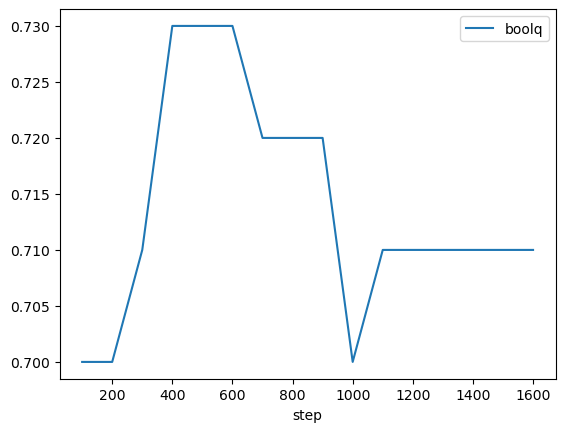

In [81]:
metrics_df[["step", "boolq"]].dropna().set_index("step").plot()

<Axes: xlabel='step'>

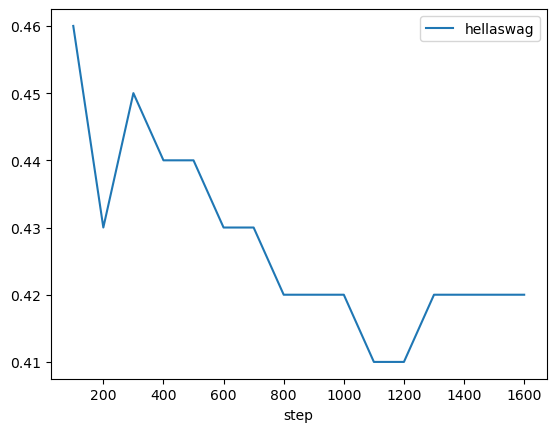

In [82]:
metrics_df[["step", "hellaswag"]].dropna().set_index("step").plot()

  7%|██▍                               | 219/3000 [1:57:09<24:47:40, 32.10s/it]


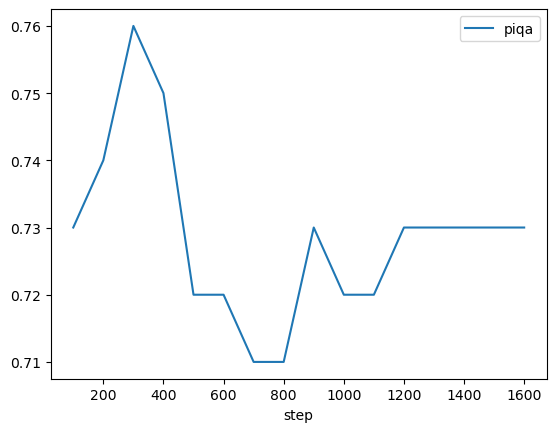

In [83]:
metrics_df = df[["step", "piqa"]].dropna().set_index("step").plot()

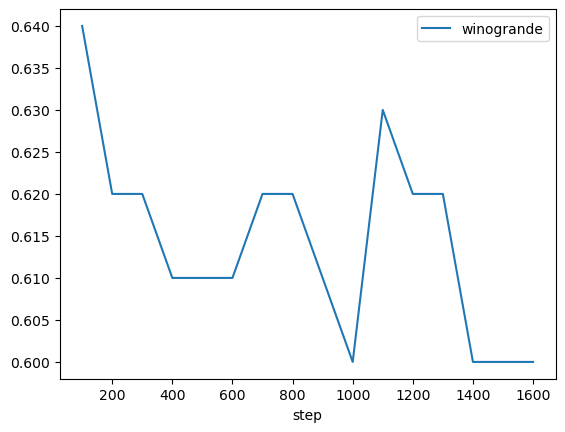

In [84]:
metrics_df = df[["step", "winogrande"]].dropna().set_index("step").plot()

In [85]:
eval_df = df[["step", "eval_alpaca_loss", "eval_wikitext_loss"]].set_index("step")

<Axes: xlabel='step'>

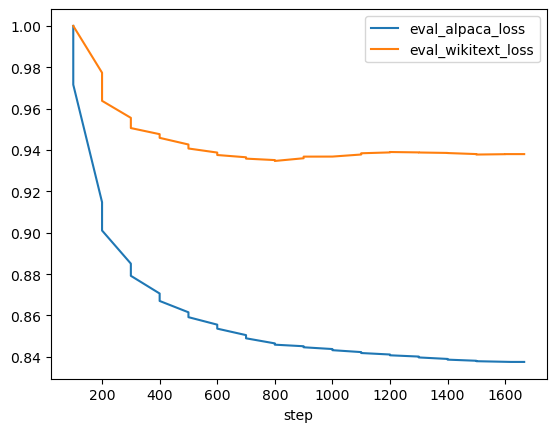

In [86]:
(eval_df / eval_df.max()).interpolate(method='linear').plot()

<Axes: xlabel='step'>

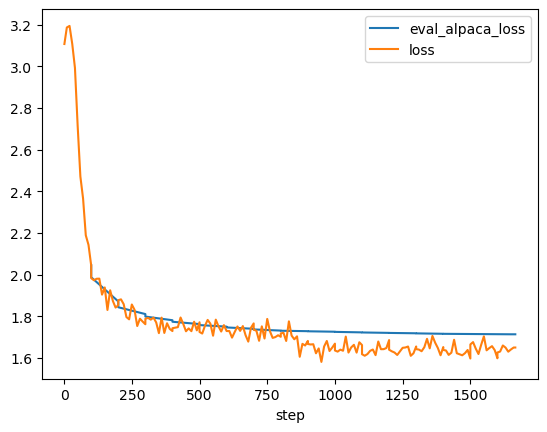

In [87]:
df[["step", "eval_alpaca_loss", "loss"]].set_index("step").interpolate(method='linear').plot()